# Dimensionality reduction of samples
All embeddings are based on non-averaged RPKUM data and for visualisation the averaged RPKUM data is transformed with the previously created embedding. Embeddings are either based on data of all strains ('all') or AX4 only ('AX4'). Genes (features) were preselected with ImpulseDE2 to find genes that smoothly vary acorsss developmental stages in AX4 and are thus potential developmental genes. The used features are either all potentially developmental genes identified with ImpulseDE2 ('variable'), top 2000 genes according to ImpulseDE2 (impulse fit) ('top') or all genes that are not 0 in all samples ('nonnull'). 

In [1]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
from sklearn.decomposition import PCA
from scipy.interpolate import UnivariateSpline,splrep,splev
from sklearn.model_selection import LeaveOneOut
from collections import defaultdict 
import random
from scipy.stats import mannwhitneyu
import itertools

#from Loess import Loess
from pyloess.Loess import Loess
import pygam 

import stages_DE.stages_library
import importlib
importlib.reload(stages_DE.stages_library)
from collections import defaultdict

from networks.functionsDENet import loadPickle,savePickle
from networks.library_regulons import make_tsne, add_tsne
from stages_DE.stages_library import *


font='Arial'
matplotlib.rcParams.update({'font.family': font})

#### Load data

In [2]:
#path_main='/home/karin/Documents/'
path_main='/home/khrovatin/'
dataPath = path_main+'timeTrajectories/data/RPKUM/combined/'
pathRegulons = path_main+'timeTrajectories/data/regulons/'
pathReplicateImg = path_main+'timeTrajectories/data/replicate_image/'

In [3]:
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
conditions = pd.read_csv(dataPath + 'conditions_mergedGenes.tsv', sep='\t', index_col=None)
#averaged_data = pd.read_table(pathRegulons + 'genes_averaged_orange_AX4groups.tsv', index_col=0)
averaged_data = pd.read_table(pathRegulons + 'genes_averaged_orange.tsv', index_col=0)
# No data on server as was not used latter
if False:
    top_impulse = pd.read_table(pathReplicateImg + 'AX4_bestImpulse2000.tsv')
    variable_impulse=pd.read_table(pathReplicateImg + 'AX4_variableImpulseSigmoid.tsv')

In [4]:
#Reference datasets and scalers for data preprocessing
ref_data={}

if False:
    genes_data=genes[conditions.query('Strain =="AX4"')['Measurment']].copy().T[variable_impulse.Gene.values]
    ref_data[('AX4','variable')]=(genes_data,CustomScaler(genes_data))

    genes_data=genes[conditions.query('Strain =="AX4"')['Measurment']].copy().T[top_impulse.Gene.values]
    ref_data[('AX4','top')]=(genes_data,CustomScaler(genes_data))

genes_data=genes[conditions.query('Strain =="AX4"')['Measurment']].copy()
genes_data=genes_data[(genes_data!=0).any(axis=1)].T
ref_data[('AX4','nonnull')]=(genes_data,CustomScaler(genes_data))

if False:
    genes_data=genes.copy().T[variable_impulse.Gene.values]
    ref_data[('all','variable')]=(genes_data,CustomScaler(genes_data))

    genes_data=genes.copy().T[top_impulse.Gene.values]
    ref_data[('all','top')]=(genes_data,CustomScaler(genes_data))

genes_data=genes.copy()
genes_data=genes_data[(genes_data!=0).any(axis=1)].T
ref_data[('all','nonnull')]=(genes_data,CustomScaler(genes_data))


In [5]:
#Reference dataset sizes
print('Reference data sizes:')
for name,data in ref_data.items():
    data=data[0]
    #print(name,data.shape,'Null genes:',(data==0).all().sum())
    print('%s %s: \t%d samples\t%d genes/features'%(name+data.shape))

Reference data sizes:
AX4 nonnull: 	88 samples	12316 genes/features
all nonnull: 	486 samples	12431 genes/features


In [5]:
#Reference dataset sizes - OLD readout
print('Reference data sizes:')
for name,data in ref_data.items():
    data=data[0]
    #print(name,data.shape,'Null genes:',(data==0).all().sum())
    print('%s %s: \t%d samples\t%d genes/features'%(name+data.shape))
    

Reference data sizes:
AX4 variable: 	88 samples	10121 genes/features
AX4 top: 	88 samples	2000 genes/features
AX4 nonnull: 	88 samples	12316 genes/features
all variable: 	486 samples	10121 genes/features
all top: 	486 samples	2000 genes/features
all nonnull: 	486 samples	12431 genes/features


Readout of above cell: 

Reference data sizes:

AX4 variable: 	88 samples	10121 genes/features

AX4 top: 	88 samples	2000 genes/features

AX4 nonnull: 	88 samples	12316 genes/features

all variable: 	486 samples	10121 genes/features

all top: 	486 samples	2000 genes/features

all nonnull: 	486 samples	12431 genes/features



#### Some plot parameters

In [6]:
#For each strain group use different linetype for each strain
linestyles=['solid','dashed','dotted','dashdot',(0, (5, 5))]
strain_linestyles=dict()
used_linestyles = defaultdict(set)
for strain in averaged_data['Strain'].unique():
    group=GROUPS[strain.split('_')[0]]
    for style in linestyles:
        if style not in used_linestyles[group]:   
            used_linestyles[group].add(style)
            strain_linestyles[strain]=style
            break

In [7]:
# Sizes and alpha for plot
linewidth_mutant=2
alpha_mutant=0.7
linewidth_AX4=5
alpha_AX4=1
size_mutant=30
scale_size_AX4=linewidth_AX4/linewidth_mutant

In [8]:
#Plot order
strains=list(conditions['Strain'].unique())
plot_order=conditions[['Strain','Group']].copy()
plot_order['Group'] = pd.Categorical(plot_order['Group'], 
                      categories=['agg-','prec','WT','sFB','tag','cud','lag_dis','tag_dis'],
                      ordered=True)
plot_order=list(plot_order.sort_values('Group')['Strain'].unique())
plot_order.remove('AX4')
plot_order=plot_order+['AX4']

In [9]:
images=dict()

### tSNE

In [ ]:
log=True
scale='m0s1'
only_plot_params=False
for (ref_strains,ref_genes),(data,scaler) in ref_data.items():
    print(ref_strains,ref_genes,data.shape)
    
    if not only_plot_params:
        #Scale reference
        data = pd.DataFrame(scaler.transform(data,log=log,scale=scale), index=data.index, columns=data.columns)
        # tSNE
        tsne = make_tsne(data=data, perplexities_range=[int(data.shape[0]/10), int(data.shape[0]/3.2)], 
                         exaggerations=[1, 1], momentums=[0.6, 0.9], random_state=0)

    plot_data = pd.DataFrame()
    #For embedding other strains onto reference
    #strains=list(conditions['Strain'].unique())
    for strain in strains:
        # Prepare averaged strain data
        data_strain = averaged_data.query('Strain =="'+strain+'"')
        times=data_strain['Time']
        if not only_plot_params:
            data_strain=data_strain[data.columns]
            print(strain,data_strain.shape)
            # Scale averaged starin data
            data_strain = pd.DataFrame(scaler.transform(data_strain,log=log,scale=scale), index=data_strain.index, 
                                       columns=data_strain.columns)
            # tSNE embedd strain data
            tsne2 = add_tsne(tsne1=tsne, data2=data_strain)
            # Data for plotting
            plot_data_strain=pd.DataFrame(tsne2, index=data_strain.index, columns=['x', 'y'])
        else:
            plot_data_strain=images[('tSNE',ref_strains,ref_genes)][2].query(
                'Strain == "'+strain+'"').copy()[['x','y']]
        width=linewidth_mutant
        alpha=alpha_mutant
        size=size_mutant
        if strain=='AX4':
            width=linewidth_AX4
            alpha=alpha_AX4
            #size=size*scale_size_AX4
        size1=size
        size0=size/10
        plot_data_strain['width']=[width]*plot_data_strain.shape[0]
        plot_data_strain['alpha']=[alpha]*plot_data_strain.shape[0]
        plot_data_strain['Time']=times
        plot_data_strain['size'] = pp.minmax_scale(plot_data_strain['Time'], (size0, size1))
        plot_data = plot_data.append(plot_data_strain)

    plot_data = pd.concat([plot_data,averaged_data.loc[plot_data.index,'Strain']], axis=1, sort=True)
    plot_data['Group']=[GROUPS[strain.split('_')[0]] for strain in plot_data['Strain']]
    plot_data['linestyle']=[strain_linestyles[strain] for strain in plot_data['Strain']]
    
    #Plot
    fig, ax = plt.subplots(figsize=(10,10))
    dim_reduction_plot(plot_data, plot_by='Strain', fig_ax=(fig, ax), order_column='Time', 
                       colour_by_phenotype=False,
                       add_name=True,fontsize=10,plot_order=plot_order)
    ax.axis('off')
    fig.suptitle(" t-SNE based on "+ref_strains+' strain(s) with '+ref_genes+' genes')
    #Save plot and plot data
    images[('tSNE',ref_strains,ref_genes)]=(fig,ax,plot_data)

### PCA

In [ ]:
log=True
scale='m0s1'
only_plot_params=False
for (ref_strains,ref_genes),(data,scaler) in ref_data.items():
    print(ref_strains,ref_genes,data.shape)
    
    if not only_plot_params:
        #Scale reference
        data = pd.DataFrame(scaler.transform(data,log=log,scale=scale), index=data.index, columns=data.columns)
        # PCA
        pca = PCA(n_components=1, random_state=0)
        pca.fit(data)


    plot_data = pd.DataFrame()
    #For embedding other strains onto reference
    #strains=list(averaged_data['Strain'].unique())
    for strain in strains:
        #Prepare averaged strain data
        data_strain = averaged_data.query('Strain =="'+strain+'"')
        times=data_strain['Time']
        if not only_plot_params:
            data_strain=data_strain[data.columns]
            print(strain,data_strain.shape)
            # Scale averaged starin data
            data_strain = pd.DataFrame(scaler.transform(data_strain,log=log,scale=scale), index=data_strain.index, 
                                       columns=data_strain.columns)
            # PCA embedd strain data
            pca_transformed = pca.transform(data_strain).ravel()
            # Data for plotting
            plot_data_strain=pd.DataFrame({'x': times, 'y': pca_transformed})
        else:
            plot_data_strain=images[('PCA',ref_strains,ref_genes)][2].query(
                'Strain == "'+strain+'"').copy()[['x','y']]
        width=linewidth_mutant
        alpha=alpha_mutant
        size=size_mutant/3
        if strain=='AX4':
            width=linewidth_AX4
            alpha=alpha_AX4
            size=size*scale_size_AX4
        plot_data_strain['width']=[width]*plot_data_strain.shape[0]
        plot_data_strain['alpha']=[alpha]*plot_data_strain.shape[0]
        plot_data_strain['size'] = [size]*plot_data_strain.shape[0]
        plot_data = plot_data.append(plot_data_strain)

    plot_data = pd.concat([plot_data,averaged_data.loc[plot_data.index,['Strain']]], axis=1, sort=True)
    plot_data['Group']=[GROUPS[strain.split('_')[0]] for strain in plot_data['Strain']]
    plot_data['linestyle']=[strain_linestyles[strain] for strain in plot_data['Strain']]
    
    #Plot
    fig, ax = plt.subplots(figsize=(10,10))
    dim_reduction_plot(plot_data, plot_by='Strain', fig_ax=(fig, ax), order_column='x', 
                       colour_by_phenotype=False, legend_groups='upper left', 
                       add_name=True,fontsize=10,plot_order=plot_order)
    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Time')
    ax.set_ylabel('PC1')
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    fig.suptitle(" PC1 vs time based on "+ref_strains+' strain(s) with '+ref_genes+' genes')
    #Save plot and plot data
    images[('PCA',ref_strains,ref_genes)]=(fig,ax,plot_data)

## Selected tSNE and PCA
(Most) informative tSNE and PCA plots.

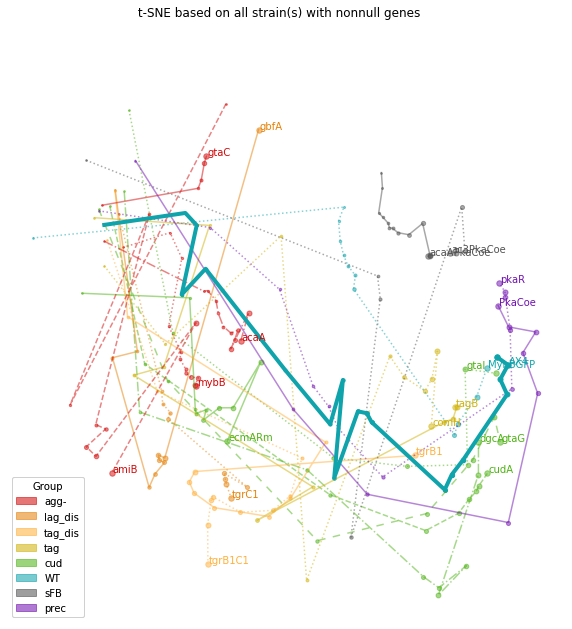

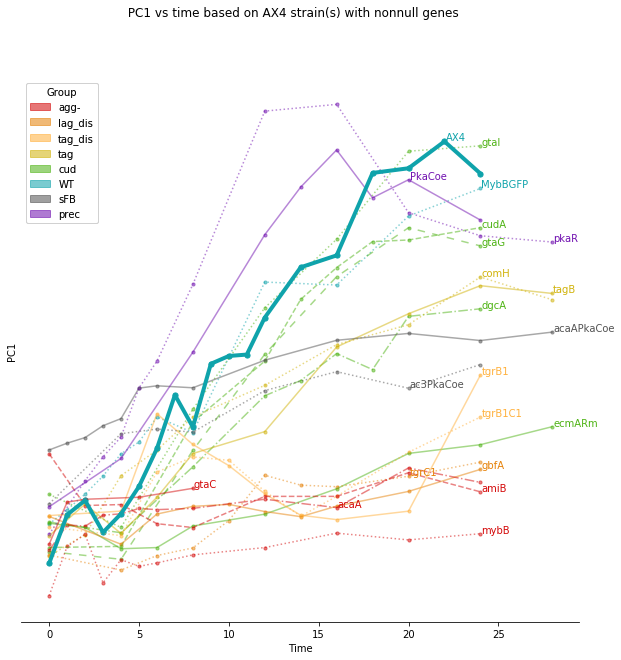

In [321]:
display(images[('tSNE','all','nonnull')][0]) 
display(images[('PCA','AX4','nonnull')][0])

Some variability in AX4 may be due to different number of averaged replicates at different time points. For example, the AX4 PCA 'paths' of separately averaged AX4 replicate groups (FD, PE, SE) vary somewhat less across neighbouring data points (not shown). 

## All plots
Using all reference and features combinations.

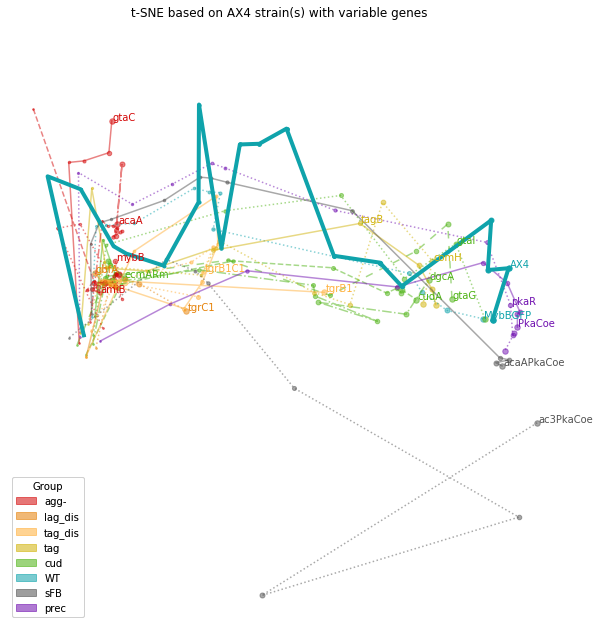

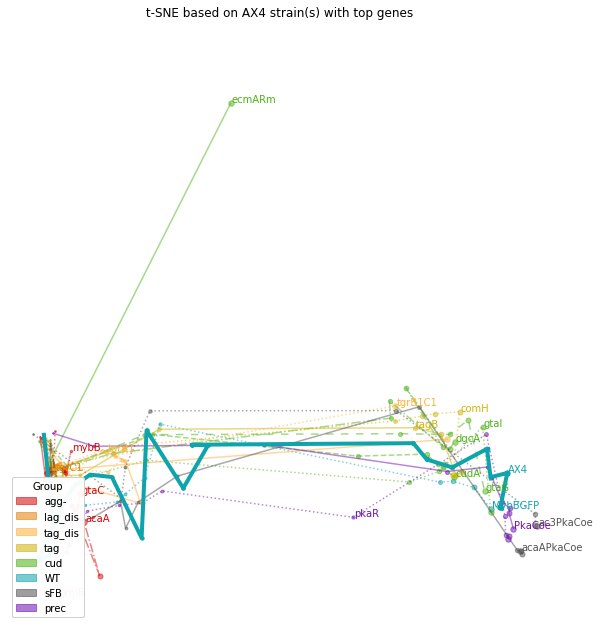

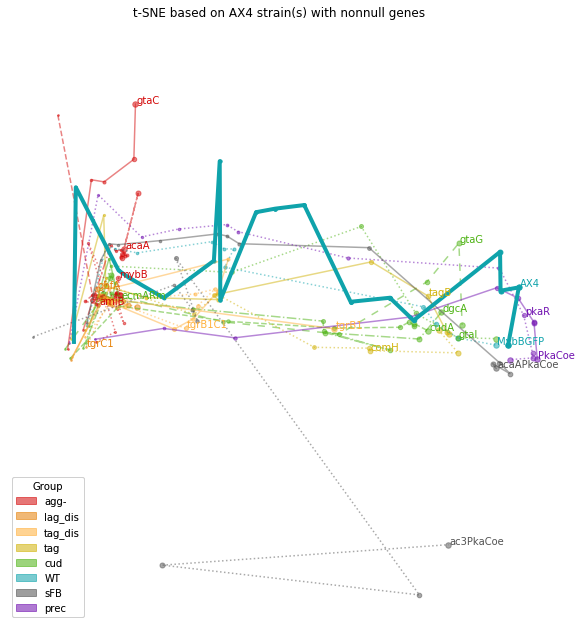

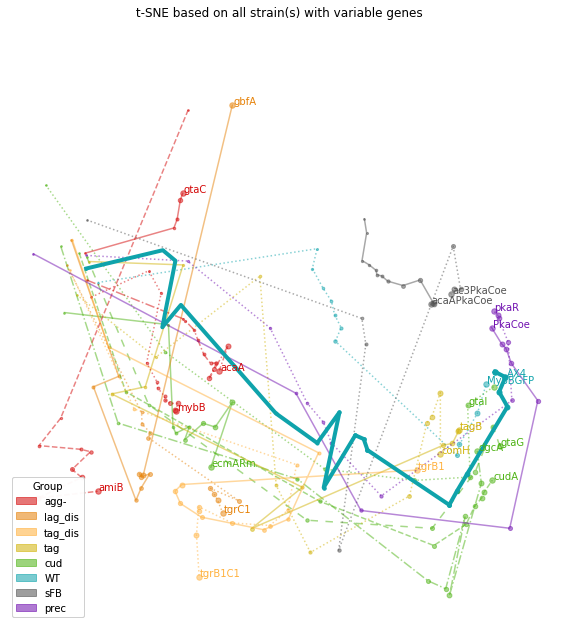

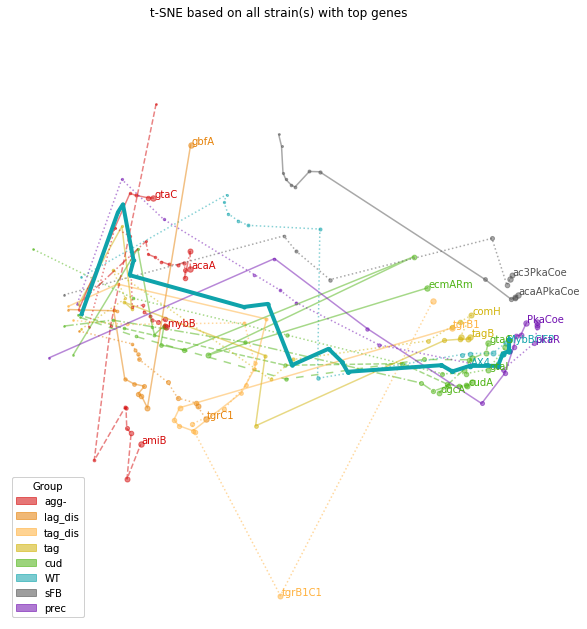

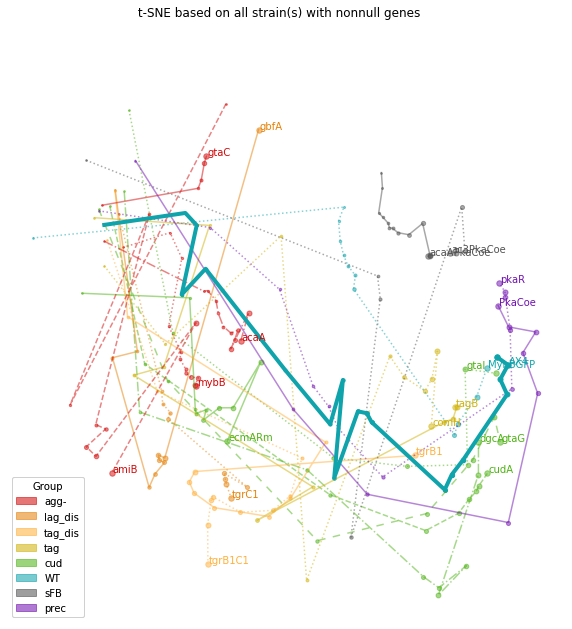

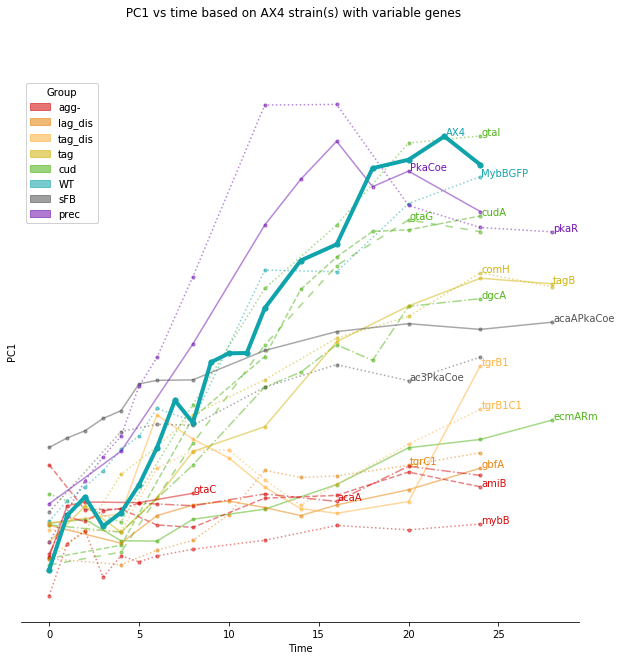

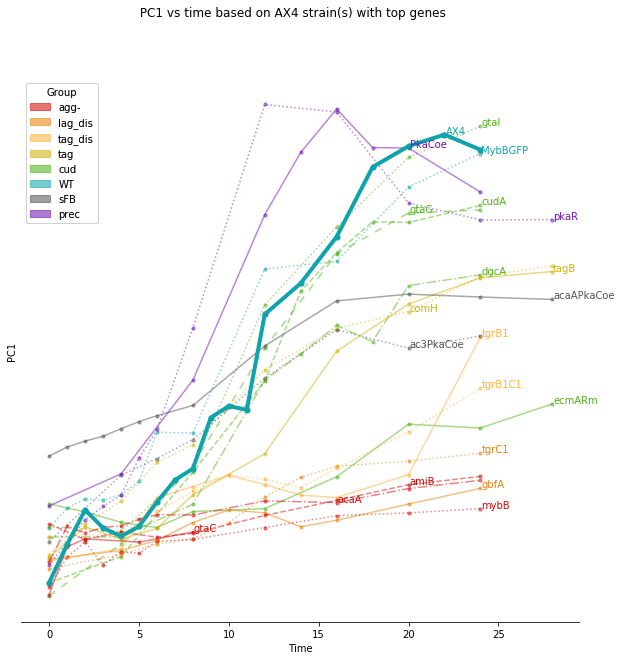

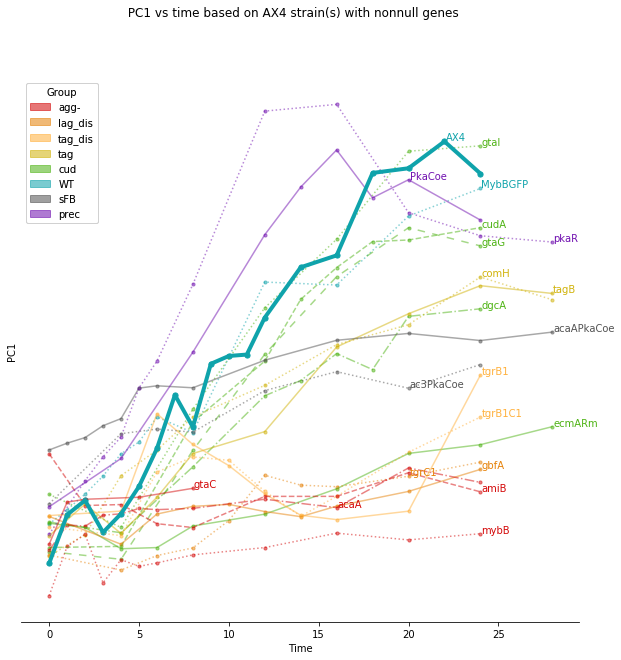

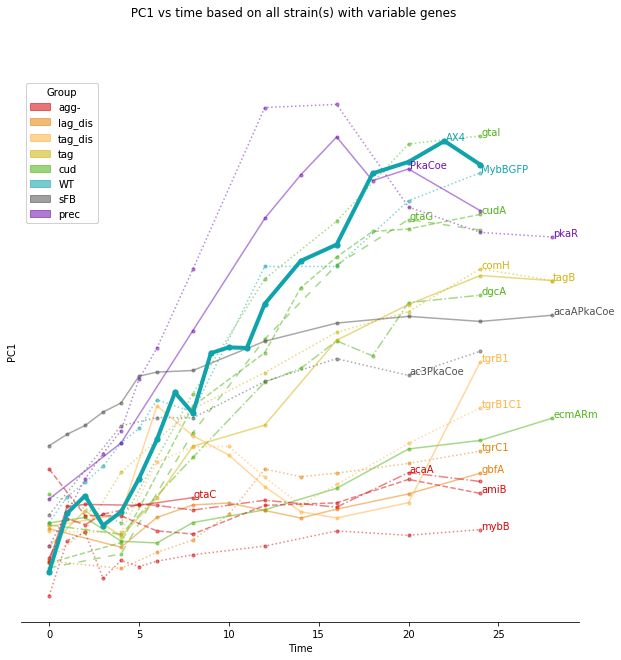

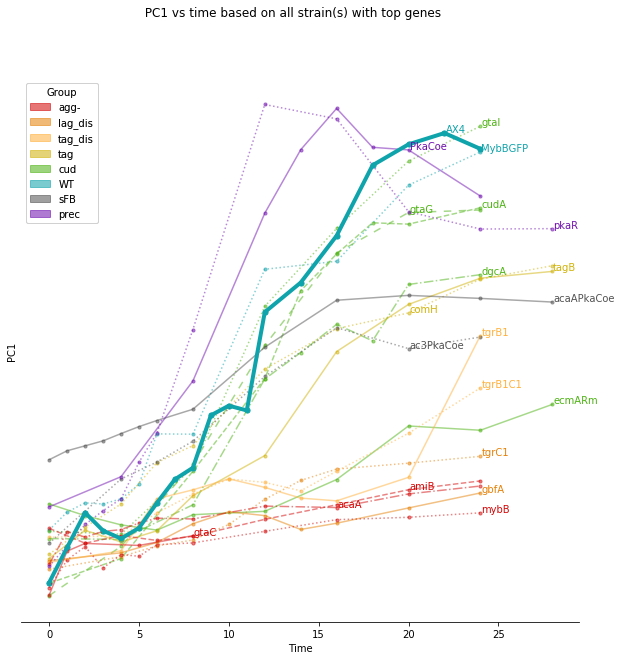

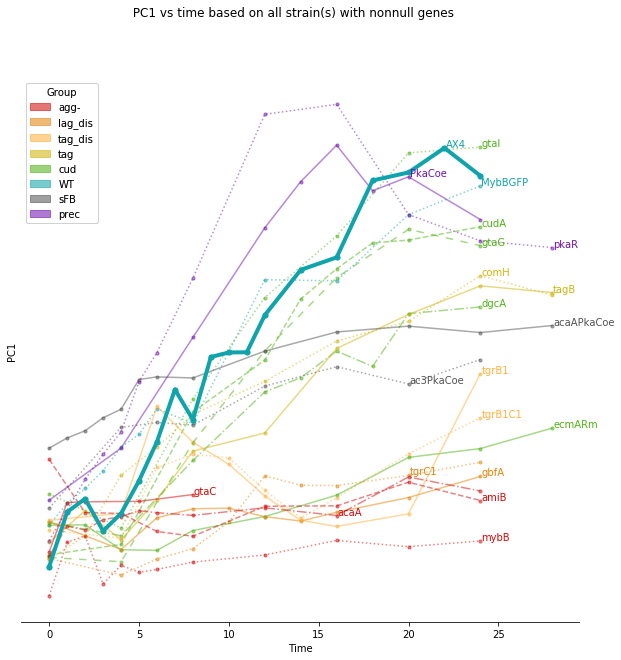

In [320]:
for fig,ax,plot_data in images.values():
    display(fig)

## Load PCA data and transform strains

In [6]:
#Reference PCA fit
log=True
scale='m0s1'
REF_STRAINS='AX4'
REF_GENES='nonnull'

DATA_REFERENCE,SCALER=ref_data[(REF_STRAINS,REF_GENES)]
print(REF_STRAINS,REF_GENES,DATA_REFERENCE.shape)

#Scale reference
DATA_REFERENCE = pd.DataFrame(SCALER.transform(DATA_REFERENCE,log=log,scale=scale), 
                              index=DATA_REFERENCE.index, columns=DATA_REFERENCE.columns)
# PCA
#pca = PCA(n_components=1, random_state=0)
#pca=pca.fit(DATA_REFERENCE)
#savePickle(pathReplicateImg+'PCA_'+REF_STRAINS+REF_GENES+'_scale'+scale+'log'+str(log)+'.pkl',pca)
pca=loadPickle(pathReplicateImg+'PCA_'+REF_STRAINS+REF_GENES+'_scale'+scale+'log'+str(log)+'.pkl')

AX4 nonnull (88, 12316)


In [18]:
# Strains PCA of all points
data_strains = genes[conditions['Measurment']].T[DATA_REFERENCE.columns]
data_strains = pd.DataFrame(SCALER.transform(data_strains,log=log,scale=scale), index=data_strains.index, 
                                       columns=data_strains.columns)
PCA_TRANSFORMED = pca.transform(data_strains).ravel()

In [96]:
# Save PCA coordinates
pca_df=pd.DataFrame(PCA_TRANSFORMED,index=data_strains.index,columns=['PC1'])
pca_df['Sample_short']=conditions['Short'].values
pca_df.index.name = 'Measurment'
pca_df.to_csv(pathReplicateImg+'pc1_coordinates.tsv',sep='\t')

## Explained variance

In [72]:
print('Explained variance ratio on training data(',REF_STRAINS,') from sklearn:'
      ,round(pca.explained_variance_ratio_[0] ,3))

Explained variance ratio on training data( AX4 ) from sklearn: 0.304


In [84]:
pca_named=pd.DataFrame(PCA_TRANSFORMED,index=data_strains.index)
print('Explained variance by PC1 for each strain')
for strain in conditions['Strain'].unique():
    strain_samples=conditions.query('Strain ==@strain')['Measurment']
    transformed_strain=pca_named.loc[strain_samples]
    raw_strain=data_strains.loc[strain_samples,:]
    print('%-12s%-12.3f' % (strain,transformed_strain.var()[0]/raw_strain.var().sum()))

Explained variance by PC1 for each strain
AX4         0.304       
MybBGFP     0.234       
ecmARm      0.036       
gtaI        0.175       
cudA        0.244       
dgcA        0.178       
gtaG        0.238       
tagB        0.217       
comH        0.086       
gbfA        0.031       
tgrC1       0.052       
tgrB1       0.056       
tgrB1C1     0.034       
gtaC        0.028       
mybB        0.024       
amiB        0.041       
acaA        0.025       
acaAPkaCoe  0.055       
ac3PkaCoe   0.053       
PkaCoe      0.182       
pkaR        0.199       


## Data for ploting of the choosen PCA

In [11]:
# All strains PCA data for plotting
DATA_TRANSFORMED=pd.DataFrame({'x':conditions['Time'],'y':PCA_TRANSFORMED,
       'linestyle':[strain_linestyles[strain] for strain in conditions['Strain']],
       'width':[linewidth_mutant if strain != 'AX4' else linewidth_AX4 for strain in conditions['Strain']],
       'alpha':[alpha_mutant if strain != 'AX4' else alpha_AX4 for strain in conditions['Strain']]                         
        })     
DATA_TRANSFORMED[['Group','Strain','Replicate']+PHENOTYPES]=conditions[['Group','Strain','Replicate']+PHENOTYPES]
DATA_TRANSFORMED=DATA_TRANSFORMED.sort_values('x')

In [15]:
#Load GAM models
strain_GAMs=loadPickle(pathReplicateImg+'strainGAMs.pkl')

In [57]:
#Min/max y and x axis value - takes in account GAMs and transformed data
y_values=[]
for gam_xy in strain_GAMs.values():
    y_values.extend(gam_xy[1])
y_values.extend(list(DATA_TRANSFORMED['y']))
MAX_Y=max(y_values)
MIN_Y=min(y_values)
range_y=MAX_Y-MIN_Y
#Add some extra space (for line thickness)
MAX_Y=MAX_Y+0.02*range_y
MIN_Y=MIN_Y-0.02*range_y

MIN_X=DATA_TRANSFORMED['x'].min()
MAX_X=DATA_TRANSFORMED['x'].max()
range_x=MAX_X-MIN_X
MAX_X=MAX_X+0.05*range_x
MIN_X=MIN_X-0.05*range_x

plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

def adjust_axes_lim(ax):
    """
    Adjust ax limit so that it will be at least as small as MIN_X/Y and as big as MAX_X/Y
    """
    y_min,y_max=ax.get_ylim()
    x_min,x_max=ax.get_xlim()
    
    if round(y_min,3)>=round(MIN_Y,3):
        y_min=MIN_Y
    else:
        print('min y was set to',y_min,'instead of',MIN_Y)
    if round(y_max,3)<=round(MAX_Y,3):
        y_max=MAX_Y
    else:
        print('max y was set to',y_max,'instead of',MAX_Y)
        
    if round(x_min,3)>=round(MIN_X,3):
        x_min=MIN_X
    else:
        print('min x was set to',x_min,'instead of',MIN_X)
    if round(x_max,3)<=round(MAX_X,3):
        x_max=MAX_X
    else:
        print('max x was set to',x_max,'instead of',MAX_X)
        
    ax.set_ylim(y_min,y_max)
    ax.set_xlim(x_min,x_max)

## Smoothed PCA
Fit a smoothing function over PCA embeddings of individual samples from strains. Embedding is based on AX4 data with nonnull genes. Samples are drawn as points, coloured by replicate. The smoothed fit is drawn as a line.

### Generalized Additive Model (GAM) 

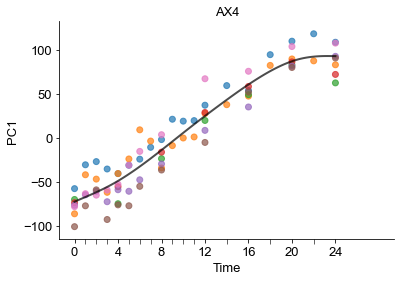

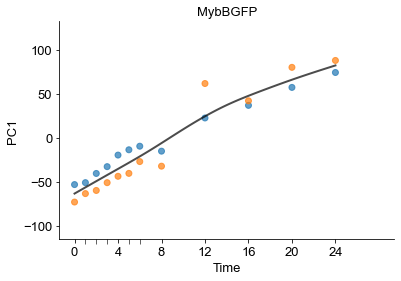

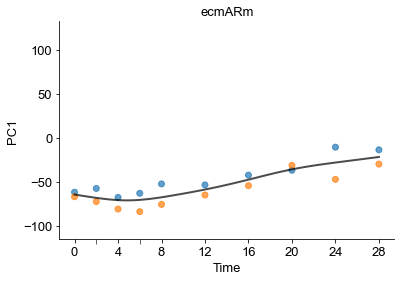

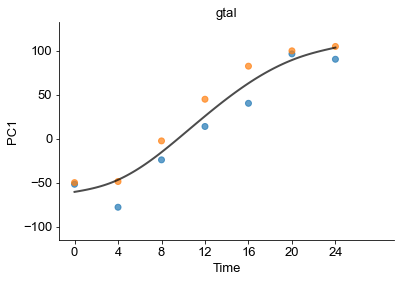

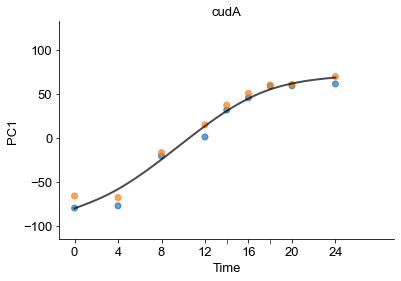

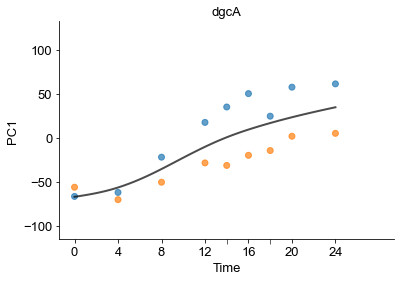

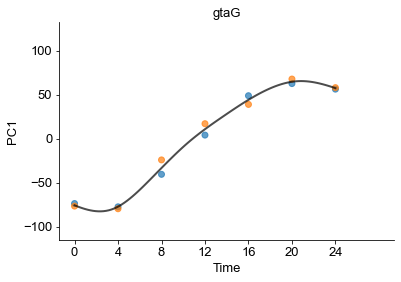

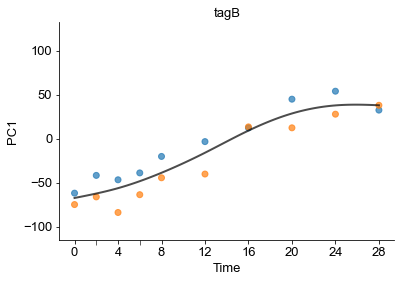

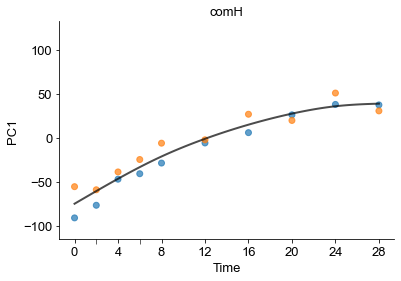

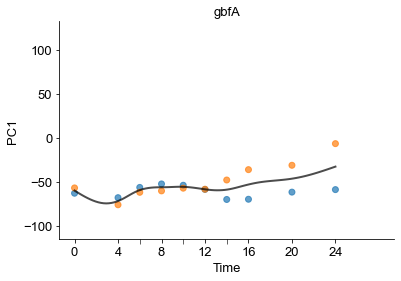

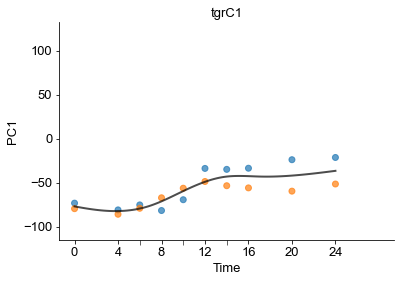

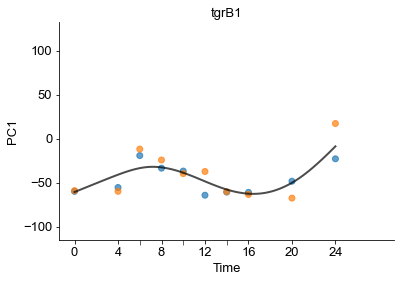

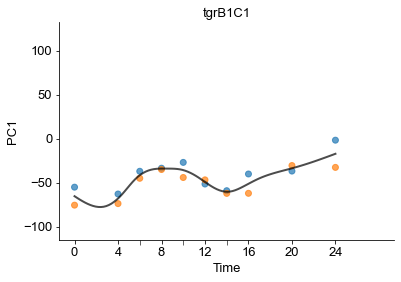

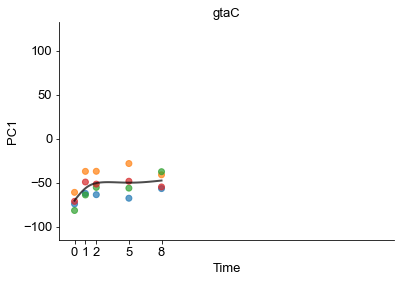

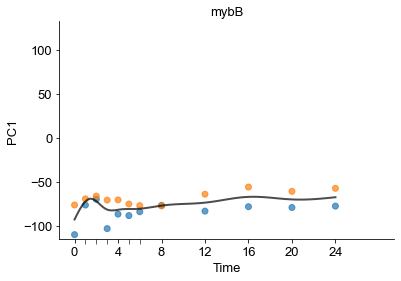

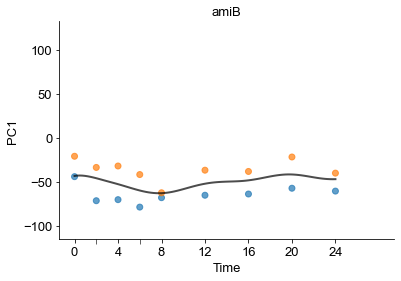

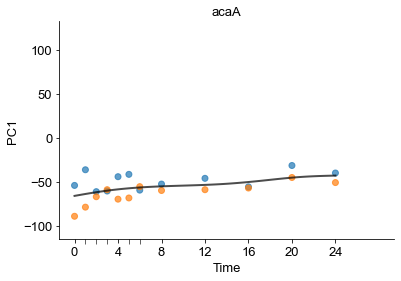

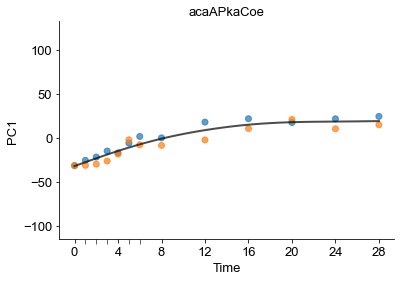

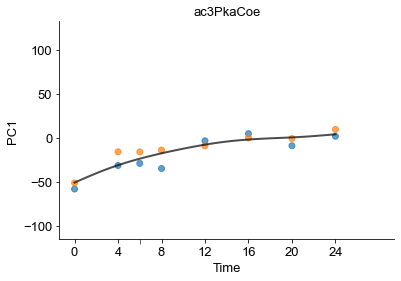

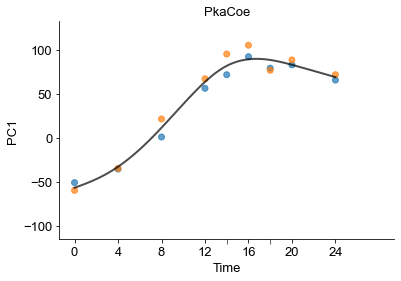

/home/karin/Documents/git/orange3venv/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


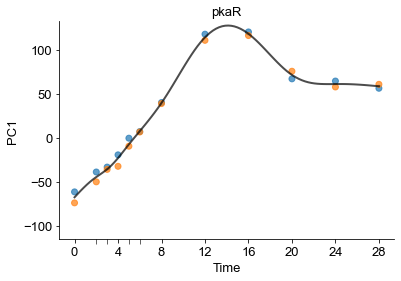

In [63]:
#GAM
only_plot=True
if not only_plot:
    strain_GAMs=dict()
#plots=[]
for strain in conditions['Strain'].unique():
    #strain='mybB'
    #Strain data (unaveraged), transform to PCA space
    conditions_strain=conditions.query('Strain =="'+strain+'"')
    times=conditions_strain['Time']
    replicates=conditions_strain['Replicate']
    data_strain = genes[conditions_strain['Measurment']].T[DATA_REFERENCE.columns]
    #print(strain,data_strain.shape)
    data_strain = pd.DataFrame(SCALER.transform(data_strain,log=log,scale=scale), index=data_strain.index, 
                                       columns=data_strain.columns)
    pca_transformed = pca.transform(data_strain).ravel()
    data_transformed=pd.DataFrame({'x':times,'y':pca_transformed})
    data_transformed=data_transformed.sort_values('x')
    
    if not only_plot:
        #CV to select GAM parameters (regularisation, n splines)
        #CV with loo x (e.g. all points at that x used for testing)
        param_combinations=list(itertools.product(*[list(np.logspace(-6, 0, 11,base=2)),[10,15,20]]))
        param_combinations=[{'lam':lam,'n_splines':n_splines} for lam,n_splines in param_combinations]

        splitter=LeaveOneOut()
        squarred_errors=defaultdict(list)
        x_list=data_transformed['x'].unique()
        for train_index, test_index in splitter.split(x_list):
            x_train,x_test=x_list[train_index],x_list[test_index]
            data_train=data_transformed[data_transformed['x'].isin(x_train)]
            data_test=data_transformed[data_transformed['x'].isin(x_test)]

            for param_idx,params in enumerate(param_combinations):
                gam=pygam.LinearGAM(pygam.s(0,**params))
                gam.fit(data_train['x'].values.reshape(-1,1),data_train['y'].values.reshape(-1,1))
                prediction=gam.predict(data_test['x'].values.reshape(-1,1))
                #MSE of all points at test location
                squared_error=(data_test['y']-prediction)**2
                squarred_errors[param_idx].extend(list(squared_error.values))

        #Select params with smallest MSE
        mese=pd.DataFrame()
        for param_idx,sqes in squarred_errors.items():
            me=np.nanmean(sqes)
            #print(param_combinations[param_idx],me)
            mese=mese.append({'param_idx':param_idx,'mese':me},ignore_index=True )
        best=mese.sort_values('mese').iloc[0,:]
        #print(best)
        params_best=param_combinations[int(best['param_idx'])]
        print(strain,params_best)

        #Make the model on whole dataset and plot it
        gam=pygam.LinearGAM(pygam.s(0,**params_best))
        gam.fit(data_transformed['x'].values.reshape(-1,1),data_transformed['y'].values.reshape(-1,1))    
    
        xs = np.linspace(min(times),max(times), 100)
        ys=gam.predict(xs)
        strain_GAMs[strain]=(xs,ys)
    else:
        xs,ys=strain_GAMs[strain]
        
    fig,ax=plt.subplots()
    
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Time')
    ax.set_ylabel('PC1')
    #ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    #ax.set_ylim(MIN_Y,MAX_Y)
    #ax.set_xlim(MIN_X,MAX_X)
    
    ax.plot(xs, ys, 'k', lw=2,alpha=0.7)
    adjust_axes_lim(ax)
    #Colour each replicate separately
    replicates_unique=list(replicates.unique())
    cmap=plt.get_cmap('tab10').colors[:len(replicates_unique)]
    rep_colours=dict(zip(replicates_unique,cmap))
    ax.scatter(times,pca_transformed,c=[rep_colours[rep] for rep in replicates],alpha=0.7)
    ax.set_title(strain,fontdict={'fontsize':13,'fontfamily':font})
    #plots.append((fig,ax))
    #display(fig)

    sampling_times=[time for time in data_transformed['x'].unique() if time%4==0]
    if strain=='gtaC':
        sampling_times=data_transformed['x'].unique()
    a=ax.set_xticks(sampling_times)
    a=ax.set_xticks(data_transformed['x'].unique(),minor=True)
    ax.tick_params(axis='x', which='minor',length=5)
    plt.savefig('/home/karin/Documents/timeTrajectories/data/replicate_image/PC1time/GAM/'+strain+'.pdf')
    display(fig)
plt.close('all')

In [25]:
if not only_plot:
    savePickle(pathReplicateImg+'strainGAMs.pkl',strain_GAMs)

### Combined GAM fits of all strains

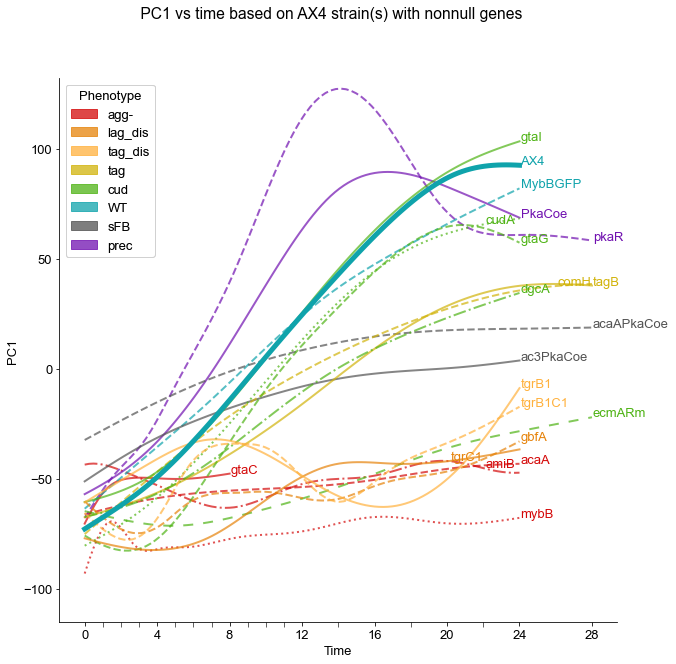

In [62]:
matplotlib.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(figsize=(10,10))
data_transformed2=DATA_TRANSFORMED.copy()
data_transformed2['alpha']=[1]*data_transformed2.shape[0]
dim_reduction_plot(DATA_TRANSFORMED, plot_by='Strain', fig_ax=(fig, ax), order_column='x', 
                   colour_by_phenotype=False, legend_groups='upper left', 
                   #add_name=False,
                   add_name=True,
                   fontsize=13,plot_order=plot_order,plot_points=False,
                  alternative_lines=strain_GAMs,sep_text=(15,30))

ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time')
ax.set_ylabel('PC1')
#ax.tick_params(axis='y', which='both', left=False, labelleft=False)
#ax.set_ylim(MIN_Y,MAX_Y)
a=fig.suptitle(" PC1 vs time based on "+REF_STRAINS+' strain(s) with '+REF_GENES+' genes',
               fontdict={'fontsize':13,'fontfamily':font})
sampling_times=[time for time in DATA_TRANSFORMED['x'].unique() if time%4==0]
a=ax.set_xticks(sampling_times)
a=ax.set_xticks(DATA_TRANSFORMED['x'].unique(),minor=True)
ax.tick_params(axis='x', which='minor',length=5)
adjust_axes_lim(ax)
#plt.savefig('/home/karin/Documents/timeTrajectories/data/replicate_image/PC1time/GAM/combined_nonannotated.pdf')
plt.savefig('/home/karin/Documents/timeTrajectories/data/replicate_image/PC1time/GAM/combined.pdf')
display(fig)
plt.close('all')

### Locally estimated scatterplot smoothing (Loess) (+ GAM)
Smooth the data points with loess. As number of x locations is relatively small the loess sometimes produces non-smooth fits. Thus the loess line predictions are also smoothed with GAM.

AX4 proportion of dataset as neighbours: 0.5
MybBGFP proportion of dataset as neighbours: 0.8
ecmARm proportion of dataset as neighbours: 0.8
gtaI proportion of dataset as neighbours: 0.5
cudA proportion of dataset as neighbours: 0.5
dgcA proportion of dataset as neighbours: 0.5
gtaG proportion of dataset as neighbours: 0.8
tagB proportion of dataset as neighbours: 0.8
comH proportion of dataset as neighbours: 0.77
gbfA proportion of dataset as neighbours: 0.8
tgrC1 proportion of dataset as neighbours: 0.77
tgrB1 proportion of dataset as neighbours: 0.8
tgrB1C1 proportion of dataset as neighbours: 0.77
gtaC proportion of dataset as neighbours: 0.65
mybB proportion of dataset as neighbours: 0.5
amiB proportion of dataset as neighbours: 0.5
acaA proportion of dataset as neighbours: 0.8
acaAPkaCoe proportion of dataset as neighbours: 0.55
ac3PkaCoe proportion of dataset as neighbours: 0.78
PkaCoe proportion of dataset as neighbours: 0.5
pkaR proportion of dataset as neighbours: 0.8


/home/karin/Documents/git/orange3venv/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


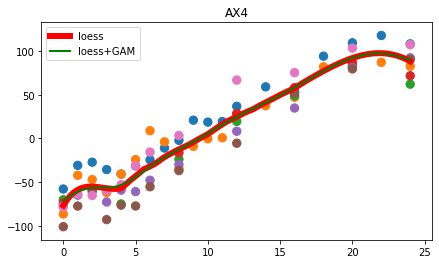

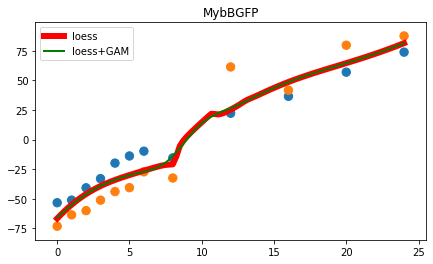

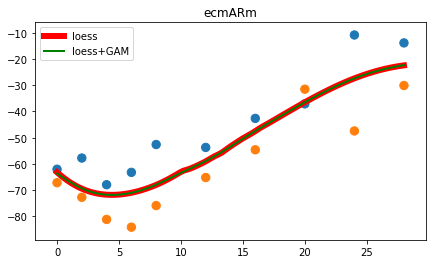

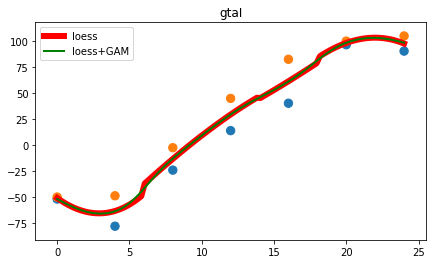

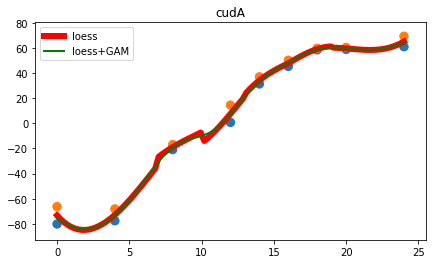

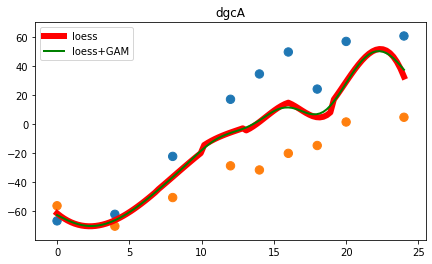

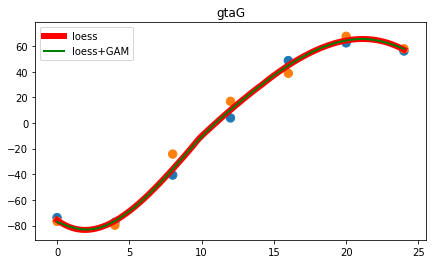

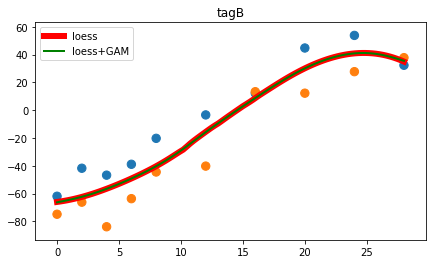

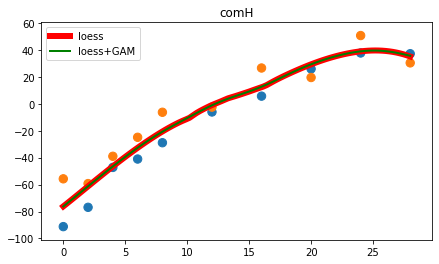

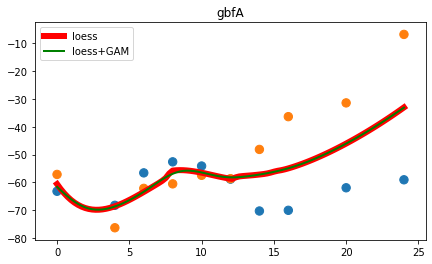

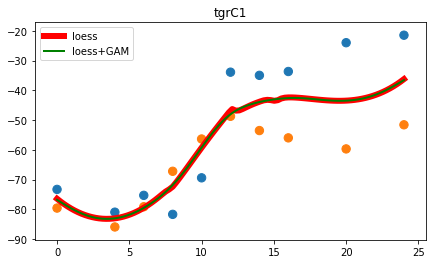

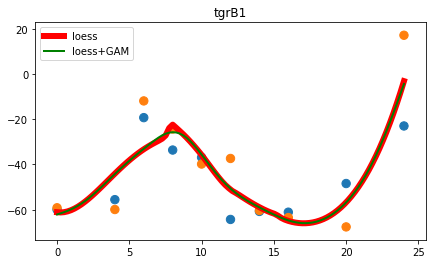

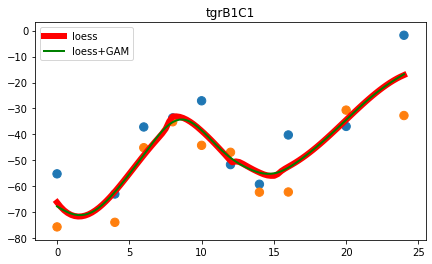

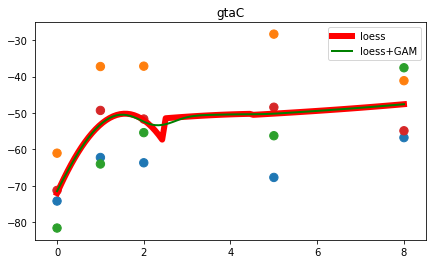

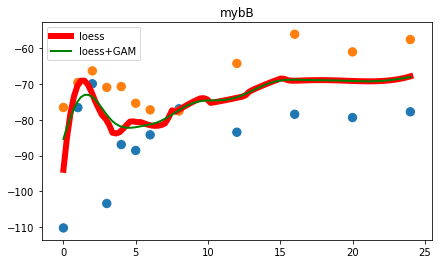

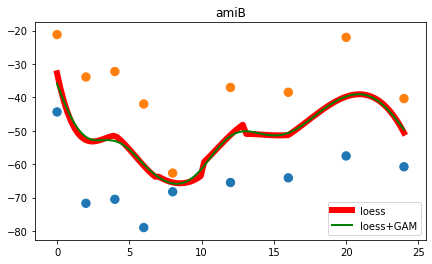

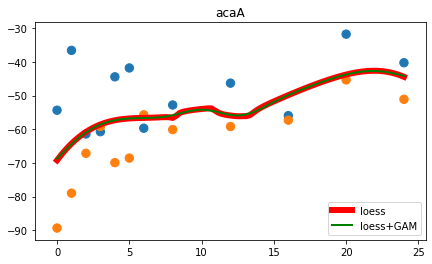

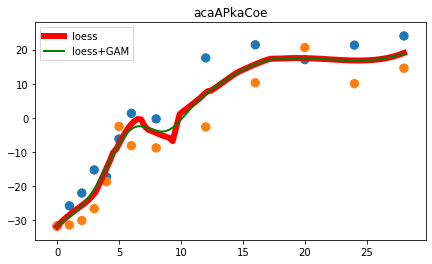

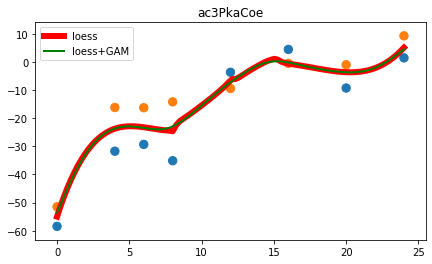

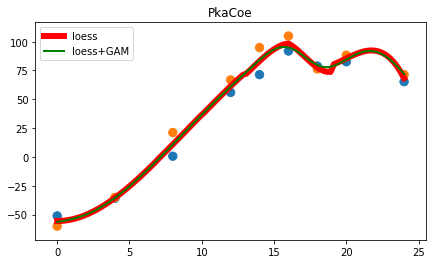

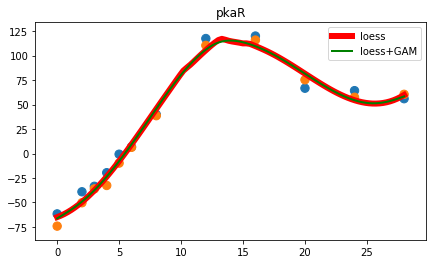

In [340]:
#Smooth with loess (+GAM)
#Loess degree
degree=3
#plots=[]
for strain in conditions['Strain'].unique():
    #Strain data
    conditions_strain=conditions.query('Strain =="'+strain+'"')
    times=conditions_strain['Time']
    replicates=conditions_strain['Replicate']
    data_strain = genes[conditions_strain['Measurment']].T[DATA_REFERENCE.columns]
    #print(strain,data_strain.shape)
    data_strain = pd.DataFrame(SCALER.transform(data_strain,log=log,scale=scale), index=data_strain.index, 
                                       columns=data_strain.columns)
    #Transform samples to PCA space
    pca_transformed = pca.transform(data_strain).ravel()
    data_transformed=pd.DataFrame({'x':times,'y':pca_transformed})
    data_transformed=data_transformed.sort_values('x')
    
    #CV loess to obtain the window (proportion of all samples to use as neighbours)
    #CV with loo x (leave all points at x as test set)
    splitter=LeaveOneOut()
    squarred_errors=defaultdict(list)
    x_list=data_transformed['x'].unique()
    for train_index, test_index in splitter.split(x_list):
        x_train,x_test=x_list[train_index],x_list[test_index]
        data_train=data_transformed[data_transformed['x'].isin(x_train)]
        data_test=data_transformed[data_transformed['x'].isin(x_test)]
        
        step=0.01
        for proportion_neigh in np.arange(0.5,0.8,step):
            loess=Loess(data_train['x'].values,data_train['y'].values,degree=degree)
            prediction=[]
            for x in data_test['x'].values:
                y=loess.estimate(x,window=int(data_train['x'].shape[0]*proportion_neigh),degree=degree)
                prediction.append(y)
            prediction=np.array(prediction)
            #MSE for all points at test x
            squared_error=(data_test['y']-prediction)**2
            squarred_errors[proportion_neigh].extend(list(squared_error.values))
            
    #Select window dataset proportion with lowest MSE
    mese=pd.DataFrame()
    for param,sqes in squarred_errors.items():
        me=np.nanmean(sqes)
        #print(param_combinations[param_idx],me)
        mese=mese.append({'param':param,'mese':me},ignore_index=True )
    best=mese.sort_values('mese').iloc[0,:]
    params_best=best['param']
    print(strain,'proportion of dataset as neighbours:',round(params_best,3))
    
    #Fit on wholedataset and predict for plotting
    loess=Loess(data_transformed['x'].values,data_transformed['y'].values,degree=degree)
    xs = np.linspace(min(times),max(times), 100)
    prediction=[]
    for x in xs:
        y=loess.estimate(x,window=int(data_transformed['x'].shape[0]*params_best),degree=degree)
        prediction.append(y)

    fig,ax=plt.subplots(figsize=(7,4))
    ax.plot(xs, prediction, 'r', lw=6,label='loess')
    
    #Fit (and regularise) GAM over the loess predictions (stretch of points for plotting) - smooth the loess
    gam=pygam.LinearGAM(pygam.s(0))
    
    gam.gridsearch(xs.reshape(-1,1),np.array(prediction).reshape(-1,1),progress=False
                  ,lam=np.logspace(-1, 10, 11,base=2)
                   ,n_splines=[5,10,20,25]
                  )
    ax.plot(xs, gam.predict(xs), 'g', linewidth=2,label='loess+GAM')
    
    replicates_unique=list(replicates.unique())
    cmap=plt.get_cmap('tab10').colors[:len(replicates_unique)]
    rep_colours=dict(zip(replicates_unique,cmap))
    ax.scatter(times,pca_transformed,c=[rep_colours[rep] for rep in replicates],s=70)
    ax.set_title(strain)
    ax.legend()
    #plots.append((fig,ax))
    #display(fig)

## Plot with average and SEM

Calculate PC1 for each sample. This is then averaged over replicates to plot the line through time. The shaded zones show standard error of the mean (SEM) around the averaged data. Points indicate individual samples and are coloured by replicate.

In [368]:
# Check that averaging before (on expression data level) and after PCA (on PCA transformed values) is the same
pca_avg=data_transformed.groupby('x').mean().values.ravel()
data_avg=data_strain.copy()
data_avg['x']=times.values
avg_pca=pca.transform(data_avg.groupby('x').mean()).ravel()
(np.round(avg_pca,6)==np.round(pca_avg,6)).all()

True

/home/karin/Documents/git/orange3venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


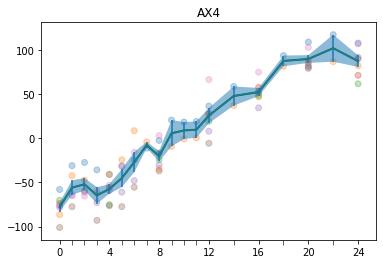

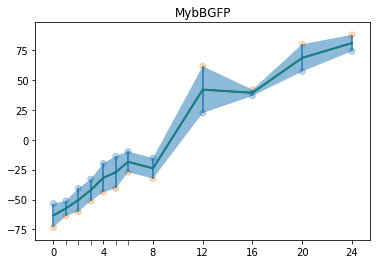

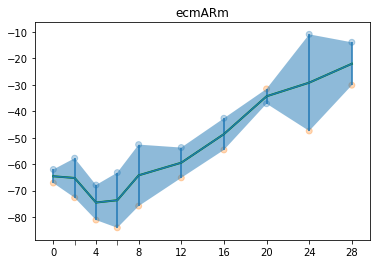

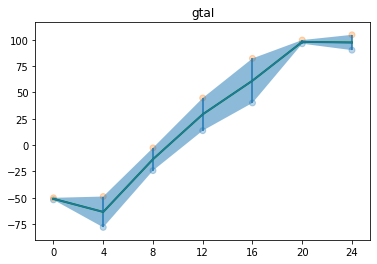

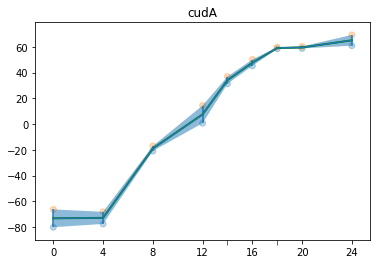

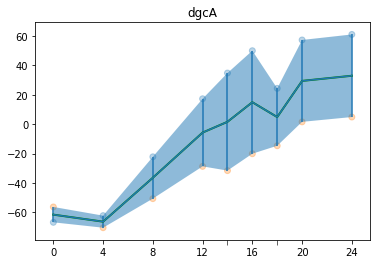

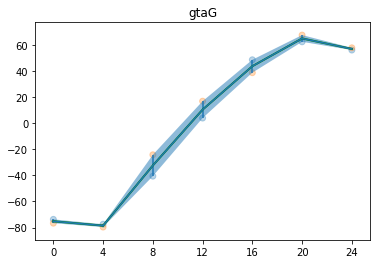

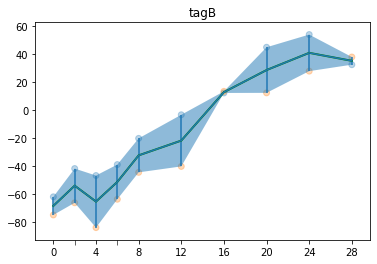

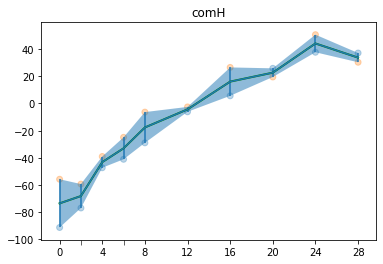

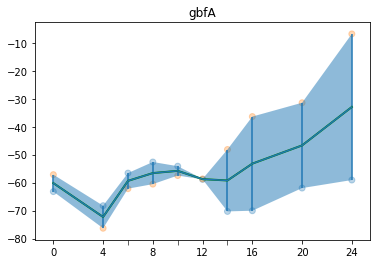

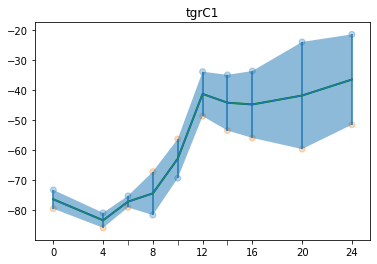

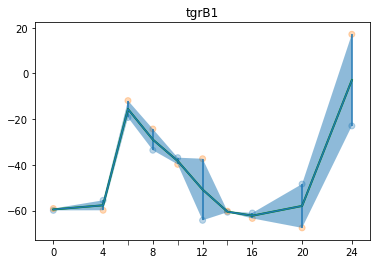

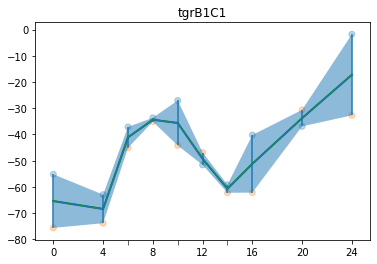

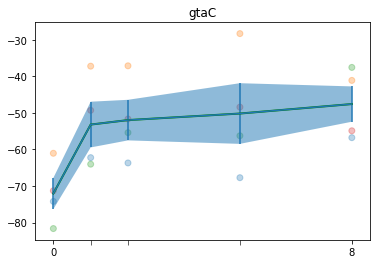

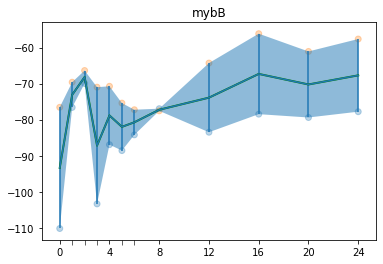

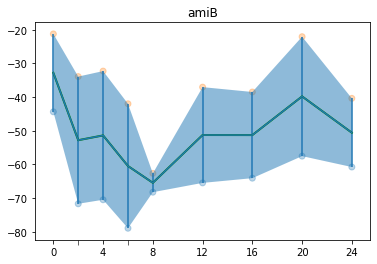

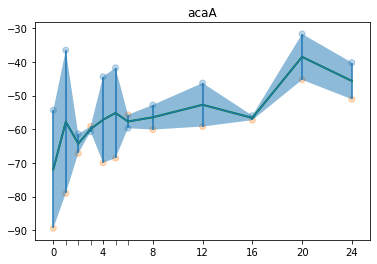

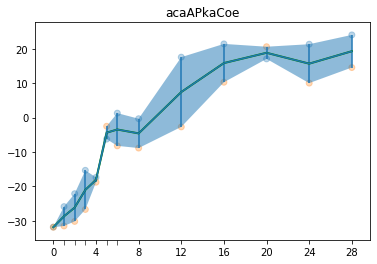

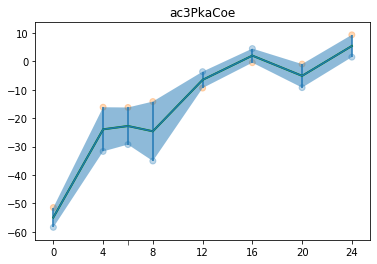

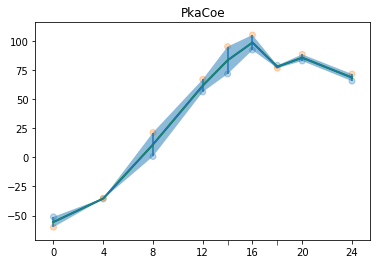

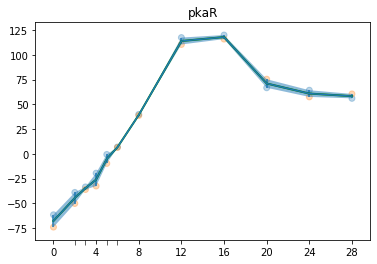

In [43]:

for strain in conditions['Strain'].unique():
    #Strain data
    conditions_strain=conditions.query('Strain =="'+strain+'"')
    times=conditions_strain['Time']
    replicates=conditions_strain['Replicate']
    data_strain = genes[conditions_strain['Measurment']].T[DATA_REFERENCE.columns]
    #print(strain,data_strain.shape)
    data_strain = pd.DataFrame(SCALER.transform(data_strain,log=log,scale=scale), index=data_strain.index, 
                                       columns=data_strain.columns)
    #Transform samples to PCA space
    pca_transformed = pca.transform(data_strain).ravel()
    data_transformed=pd.DataFrame({'x':times,'y':pca_transformed})
    data_transformed=data_transformed.sort_values('x')
    
    groupped=data_transformed.groupby(['x'])
    
    fig,ax=plt.subplots()
    x_avg=groupped.mean().index
    y_avg=groupped.mean()['y']
    sem=groupped.sem()['y']
    ax.plot(x_avg, y_avg, 'g', linewidth=2)
    
    replicates_unique=list(replicates.unique())
    cmap=plt.get_cmap('tab10').colors[:len(replicates_unique)]
    rep_colours=dict(zip(replicates_unique,cmap))
    ax.scatter(times,pca_transformed,c=[rep_colours[rep] for rep in replicates],alpha=0.3)
    ax.set_title(strain)
    ax.errorbar(x_avg, y_avg, sem)
    ax.fill_between(x_avg, y_avg-sem, y_avg+sem,alpha=0.5)
    #plots.append((fig,ax))
    #display(fig)
    sampling_times=[time for time in data_transformed['x'].unique() if time%4==0]
    a=ax.set_xticks(sampling_times)
    a=ax.set_xticks(data_transformed['x'].unique(),minor=True)
    ax.tick_params(axis='x', which='minor',length=5)
    

### Plot of PC1 mean and SEM for all strains
PC1 was calculated for each sample. PC1 values are then averaged over replicates to plot the average line through time. The shaded zones show standard error of the mean (SEM) around the averaged data. 

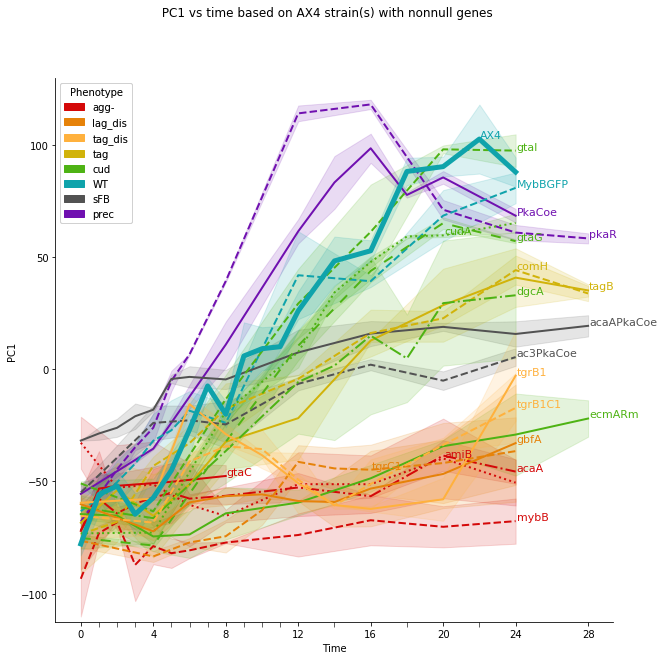

In [43]:
data_transformed2=DATA_TRANSFORMED.copy()
data_transformed2['alpha']=[1]*data_transformed2.shape[0]
fig, ax = plt.subplots(figsize=(10,10))
dim_reduction_plot(data_transformed2, plot_by='Strain', fig_ax=(fig, ax), order_column='x', 
                   colour_by_phenotype=False, legend_groups='upper left', 
                   add_name=True,fontsize=11,plot_order=plot_order,plot_points=False,
                   add_avg=True,add_sem=True,sem_alpha=0.15)

ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time')
ax.set_ylabel('PC1')
#ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.set_ylim(MIN_Y,MAX_Y)
a=fig.suptitle(" PC1 vs time based on "+REF_STRAINS+' strain(s) with '+REF_GENES+' genes')
sampling_times=[time for time in data_transformed2['x'].unique() if time%4==0]
a=ax.set_xticks(sampling_times)
a=ax.set_xticks(data_transformed2['x'].unique(),minor=True)
ax.tick_params(axis='x', which='minor',length=5)


## PC1 stages plot
Plot of samples' stages in PC1 space. Each sample was embedded in PC1 space. For each sample a point was drawn for each annotated stage. To allow visual separation of overlapping points originating from individual samples the points were jittered.

### PC1 stages plot of all strains

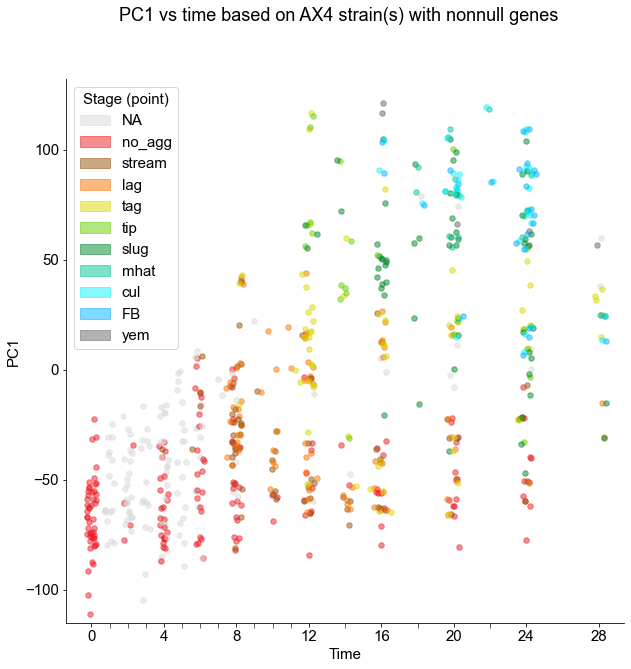

In [59]:
matplotlib.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(10,10))
dim_reduction_plot(DATA_TRANSFORMED.drop('alpha',axis=1),  plot_by='Strain', fig_ax=(fig, ax), order_column='x', 
                   colour_by_phenotype=True, legend_groups=None, legend_phenotypes='upper left',
                   add_name=False, fontsize=11, plot_order=plot_order,
                   add_avg=True, alternative_lines=strain_GAMs, sep_text=(15,30),jitter_all=True,
                  point_alpha=0.5,point_size=30,plot_lines=False,jitter_strength=(0.01,0.01))

ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time')
ax.set_ylabel('PC1')
#ax.tick_params(axis='y', which='both', left=False, labelleft=False)
#ax.set_ylim(MIN_Y,MAX_Y)
a=fig.suptitle(" PC1 vs time based on "+REF_STRAINS+' strain(s) with '+REF_GENES+' genes',
               fontdict={'fontsize':13,'fontfamily':font})
sampling_times=[time for time in DATA_TRANSFORMED['x'].unique() if time%4==0]
a=ax.set_xticks(sampling_times)
a=ax.set_xticks(DATA_TRANSFORMED['x'].unique(),minor=True)
ax.tick_params(axis='x', which='minor',length=5)
adjust_axes_lim(ax)
plt.savefig('/home/karin/Documents/timeTrajectories/data/replicate_image/PC1time/stages/combined.pdf')
display(fig)
plt.close('all')


### PC1 stages plots for individual strains
Lines are fitted GAMs, as above in PCA smoothing section. The point colour legend (stages) is the same as for the image above. Replicates are marked with different shapes.

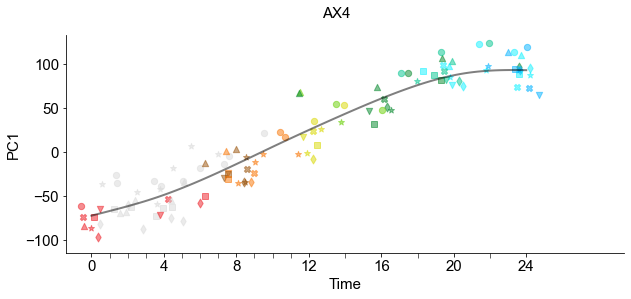

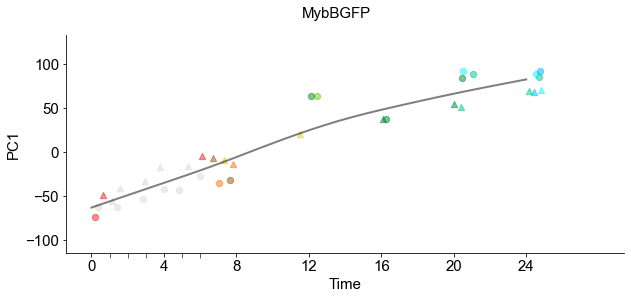

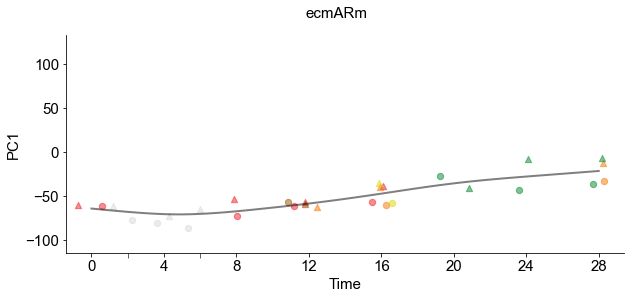

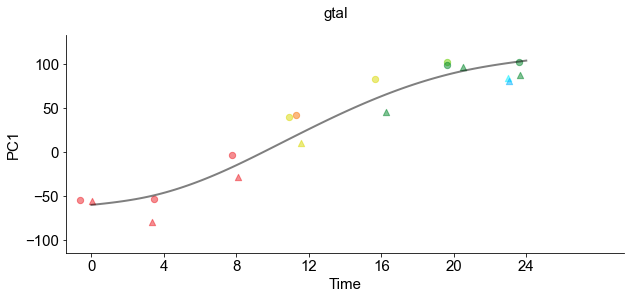

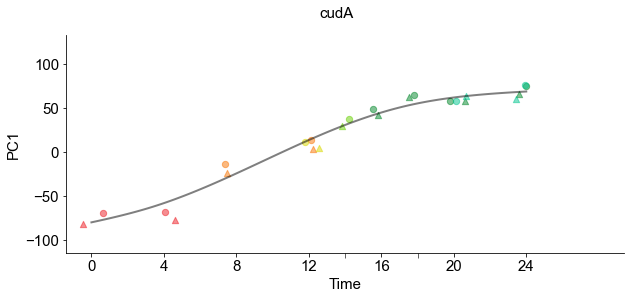

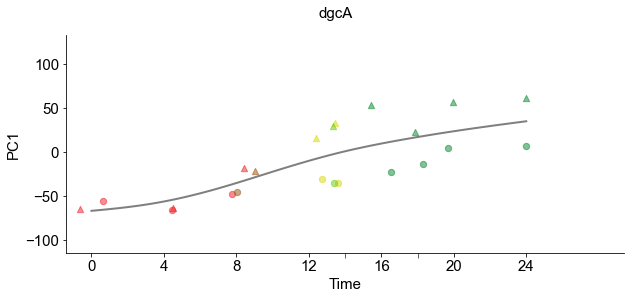

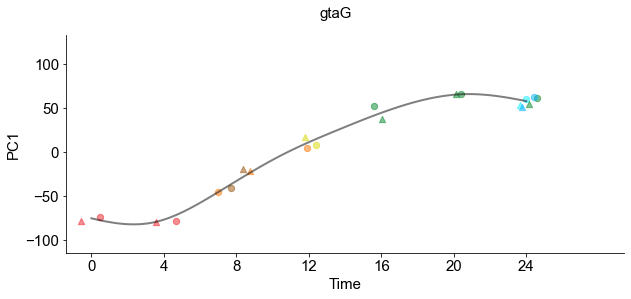

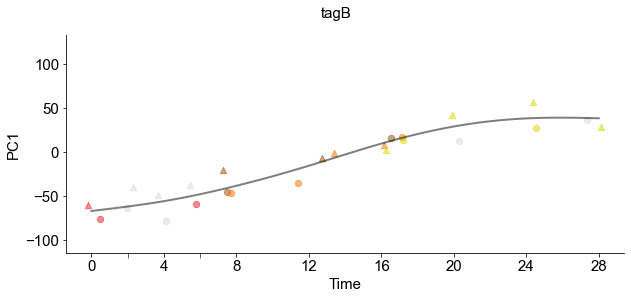

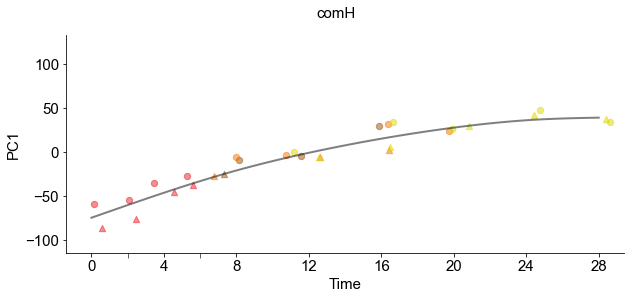

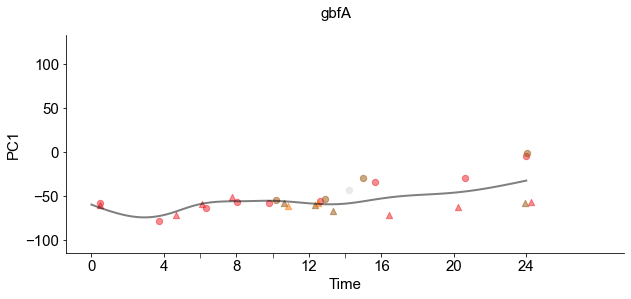

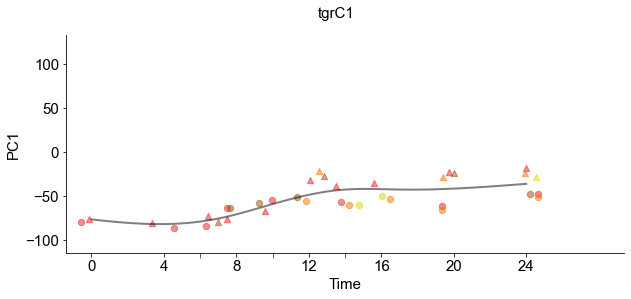

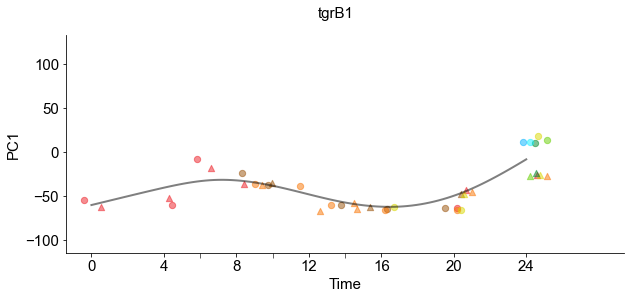

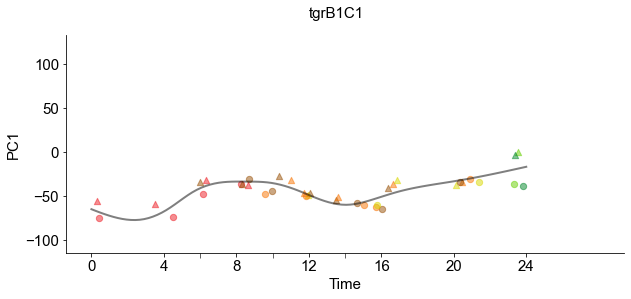

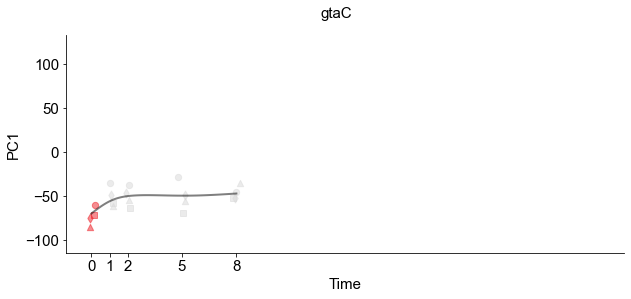

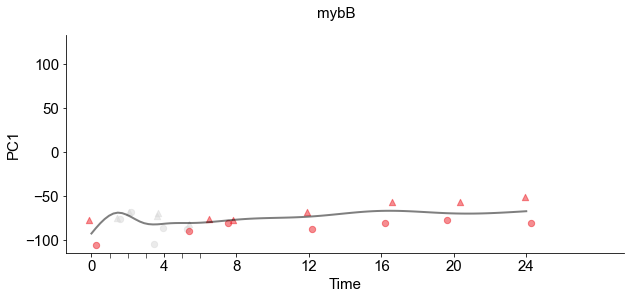

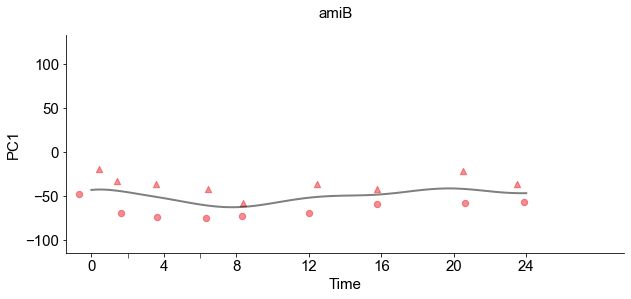

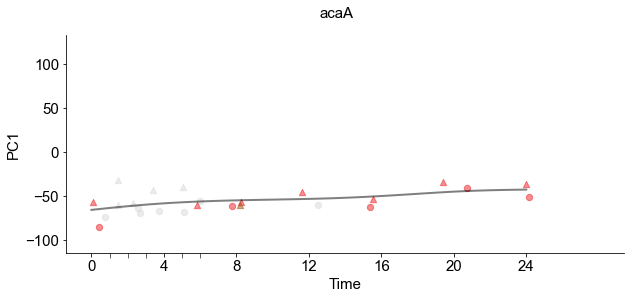

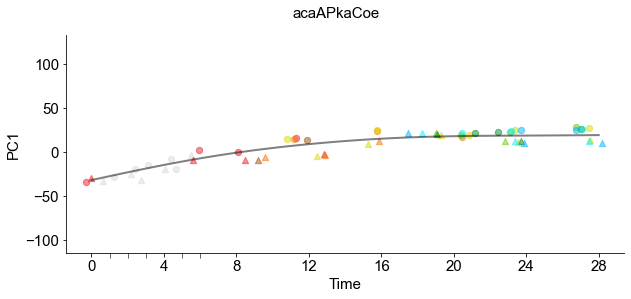

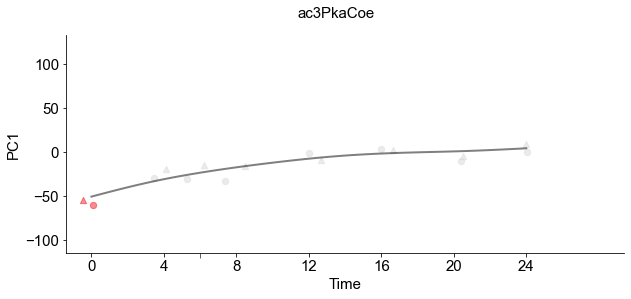

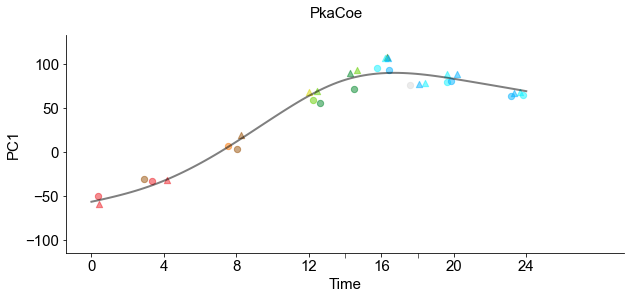

/home/karin/Documents/git/orange3venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


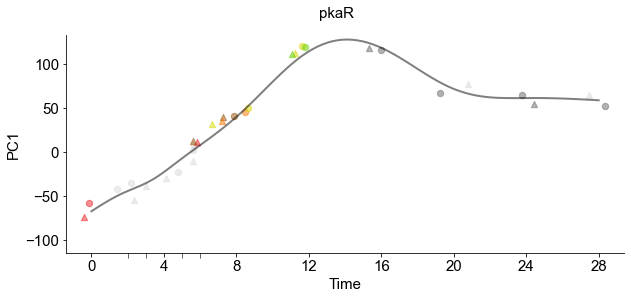

In [58]:
matplotlib.rcParams.update({'font.size': 15})
for strain in strains:
    fig, ax = plt.subplots(figsize=(10,4))
    data_plot=DATA_TRANSFORMED.query('Strain =="'+strain+'"').drop('alpha',axis=1)
    data_plot['linestyle']=['solid']*data_plot.shape[0]
    data_plot['width']=[linewidth_mutant]*data_plot.shape[0]
    replicates=list(data_plot['Replicate'].unique())
    replicates_map=dict(zip(replicates,['o','^','d','s','X','*','v']))
    data_plot['shape']=[replicates_map[rep] for rep in data_plot['Replicate']]
    dim_reduction_plot(data_plot, 
                       plot_by='Strain', fig_ax=(fig, ax), order_column='x', 
                       colour_by_phenotype=True, legend_groups=None, legend_phenotypes=None,
                       add_name=False, fontsize=11, colours={GROUPS[strain]:'black'},
                       add_avg=True, alternative_lines=strain_GAMs, sep_text=(15,30),jitter_all=True,
                      point_alpha=0.5,point_size=40,plot_lines=True,jitter_strength=(0.03,0.05))

    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Time')
    ax.set_ylabel('PC1')
    #ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    #ax.set_ylim(MIN_Y,MAX_Y)
    #ax.set_xlim(MIN_X,MAX_X)
    a=fig.suptitle(strain,fontsize=15,fontfamily=font)
    sampling_times=[time for time in data_plot['x'].unique() if time%4==0]
    if strain=='gtaC':
        sampling_times=data_plot['x'].unique()
    a=ax.set_xticks(sampling_times)
    a=ax.set_xticks(data_plot['x'].unique(),minor=True)
    ax.tick_params(axis='x', which='minor',length=5)
    adjust_axes_lim(ax)
    plt.savefig('/home/karin/Documents/timeTrajectories/data/replicate_image/PC1time/stages/'+strain+'.pdf')
    display(fig)
plt.close('all')